C:\Users\30678\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\30678\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(20, 14)
Using device: cpu
(1440, 20)


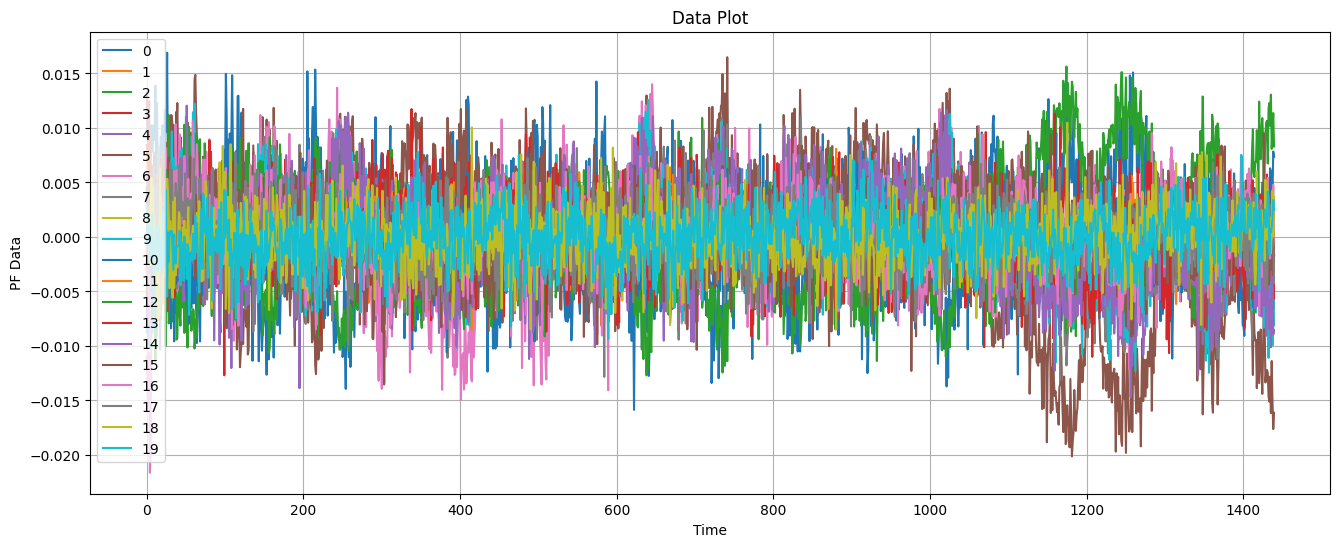

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat

# Load MATLAB file
mat_data = loadmat('matpower/topology20_14.mat')
# Access a variable inside the .mat file
A = mat_data['graph']

# Load MATLAB file
mat_data = loadmat('matpower/Hat20_14.mat')
# Access a variable inside the .mat file
H = mat_data['Bf']

print(A.shape)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def read_excel_power(file_path= ""):
    pfData = pd.read_excel(file_path, engine='openpyxl', sheet_name=0, parse_dates=['Timestamp'])
    phaseData = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, parse_dates=['Timestamp'])
    #inject = pd.read_excel(file_path, engine='openpyxl', sheet_name=2, parse_dates=['Timestamp'])
    pfData.set_index('Timestamp', inplace=True)
    phaseData.set_index('Timestamp', inplace=True)
    #inject.set_index('Timestamp', inplace=True)
    pfData= pfData.to_numpy()
    phaseData= phaseData.to_numpy()
    #inject= inject.to_numpy()
    #normalize
    pfData= pfData/np.linalg.norm(pfData, 1, axis=1, keepdims= True)
    pfData= pfData-np.mean(pfData, 0, keepdims= True)
    # # Step 2: Calculate the covariance matrix
    # cov_matrix = np.cov(pfData, rowvar=False)
    # # Step 3: Perform eigenvalue decomposition
    # eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # # Step 4: Construct the whitening matrix
    # epsilon = 1e-5  # A small constant to avoid division by zero
    # whitening_matrix = np.dot(eigenvectors, np.diag(1.0 / np.sqrt(eigenvalues + epsilon)))
    # whitening_matrix = np.dot(whitening_matrix, eigenvectors.T)
    # print(np.linalg.cond(whitening_matrix))
    # # Apply the whitening transformation to the centered data
    # pfData = np.dot(pfData, whitening_matrix)
    return pfData, phaseData
attackPfData, attackPhaseData= read_excel_power("first round/attack_all.xlsx")
attackPfData2, attackPhaseData2= read_excel_power("fdia_data.xlsx")
basePfData, basePhaseData= read_excel_power("first round/base_all.xlsx")

data= attackPfData2
print(data.shape)
plt.figure(figsize=(16, 6))
for i in range(data.shape[1]):
    #plt.plot(data.index, data[i], label=i)
    plt.plot(data[:, i], label=i)
plt.title('Data Plot')
plt.xlabel('Time')
plt.ylabel('PF Data')
plt.legend()
plt.grid(True)
plt.show()

In [2]:

type0PfData= np.concatenate([attackPfData, basePfData])
xDatas= np.concatenate([type0PfData])
print(xDatas.shape)


(960, 20)


In [16]:
# Define the model
class Net(nn.Module):
    def __init__(self, A):
        super(Net, self).__init__()

        self.H = torch.randn((20, 14), dtype= torch.float64, device=device)*1e-6 # Hidden layer
        self.H= torch.nn.Parameter(self.H)
        self.A= torch.tensor(A, device= device)
    def Hmat(self):
        return torch.abs(self.H+1)*self.A# aviod singular
    
    def InvHmat(self):
        H= self.Hmat()
        return torch.linalg.pinv(H)

    def encoder(self, x):
        Hinv= self.InvHmat()
        y1= Hinv.matmul(x.T)
        return y1
    def decoder(self, y1):
        H= self.Hmat()
        x = H.matmul(y1)
        return x.T
    def forward(self, x):
        y1= self.encoder(x)
        x_pre= self.decoder(y1)
        return x_pre
print(A.shape)
# Create the model and move it to the GPU
model = Net(A).to(device, dtype=torch.float64)
losses= []

(20, 14)


In [29]:


# Convert data to PyTorch tensors
x_tensor = torch.tensor(basePfData, dtype=torch.float64, device=device)

# Create a DataLoader
dataset = TensorDataset(x_tensor, x_tensor)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()
# criterion= nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=9e-1, weight_decay=0)



In [30]:
import copy

# Training the model
epochs = 20000
bestLoss= 1e-9
bestModel= None
for epoch in tqdm(range(epochs)):
    for inputs, label in loader:
        optimizer.zero_grad()
        y1 = model.encoder(inputs)
        p_x = model.decoder(y1)
        MSELoss = criterion(p_x, inputs)
        loss= MSELoss
        if loss.item()<bestLoss:
            bestLoss= loss.item()
            bestModel= copy.deepcopy(model)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

print("Training complete.")
print(loss)
print(MSELoss)

100%|██████████| 20000/20000 [01:07<00:00, 297.14it/s]

Training complete.
tensor(6.5338e-35, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(6.5338e-35, dtype=torch.float64, grad_fn=<MseLossBackward0>)


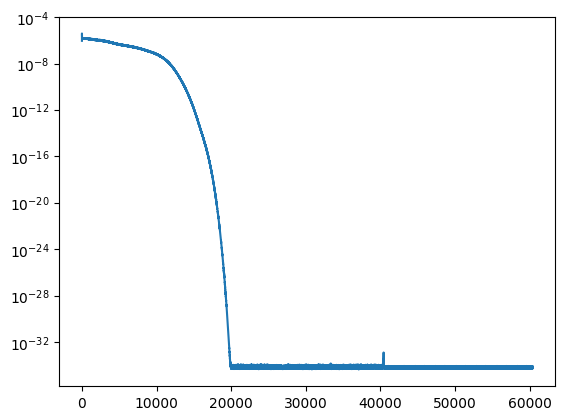

In [31]:
plt.plot(losses[:])
plt.yscale("log")
#plt.xscale("log")

In [32]:
portion= bestModel.Hmat().cpu().detach().numpy()/(H+1e-18)
print(portion.sum(1)/2)


[0.58503888 0.40723543 0.86574811 0.88073948 0.54761381 0.92609542
 0.28089712 0.82276059 2.15462244 0.62086137 1.01832897 1.09346813
 0.91235705 0.17614983 0.7633037  0.68545131 1.2148283  0.83777625
 1.043315   1.26118132]


Text(0, 0.5, 'Reconstruction Errors')

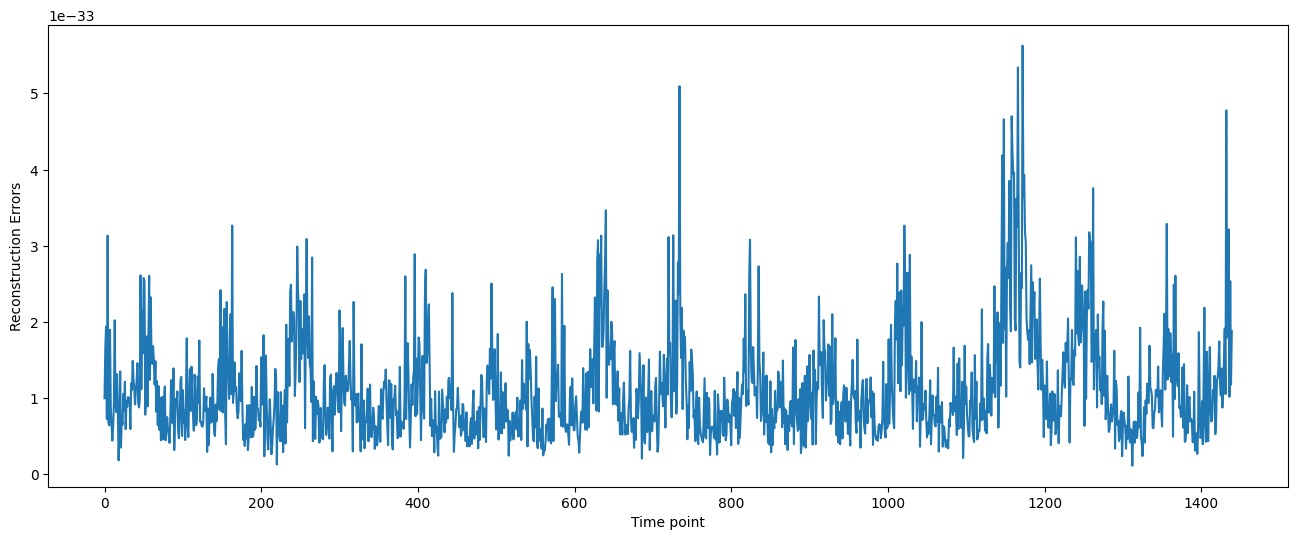

In [34]:
def apply_mean_filter_2d(data, window_size):
    # Define the filter kernel
    filter_kernel = np.ones(window_size) / window_size
    # Initialize the output array with the same shape as input
    filtered_data = np.zeros((data.shape[0]-window_size+1, data.shape[1]))
    # Apply the filter along each row
    for i in range(data.shape[1]):
        filtered_data[:, i] = np.convolve(data[:, i], filter_kernel, mode='valid')
    return filtered_data

x_test_tensor = torch.tensor(attackPfData2, dtype=torch.float64, device=device)
y1= bestModel.encoder(x_test_tensor)
o_x= bestModel.decoder(y1)
bias= torch.square(x_test_tensor-o_x).detach().cpu().numpy()
bias= apply_mean_filter_2d(bias, 1).sum(axis=1)
plt.figure(figsize=(16, 6))
plt.plot(bias)
plt.xlabel("Time point")
plt.ylabel("Reconstruction Errors")